<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Univariate with DL frameworks



# What is an univariate LSTM?
<hr style="border:2px solid black"> </hr>


- These are problems where there is a **single series of observations**.
- A model is required to learn from the series of past observations to predict the next value in the sequence.
- We'll investigate 6 flavours of the LSTM ANNs:
    - Data Preparation
    - Vanilla LSTM
    - Stacked LSTM
    - Bidirectional LSTM
    - CNN LSTM
    - ConvLSTM
   


# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Helper functions

In [2]:
def plotLearningHistory(history):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.yscale('log')
    ax.minorticks_on()
    plt.show()

In [3]:
def predictNextValue(model, x_input, conv = False):
    """Predict next value in the sequence.
    """
    if conv == False:
        # [No_rows, No_Steps]
        x_input = x_input.reshape(1, -1)
        print(x_input.shape)

        # [No_rows, No_Steps, No_features]
        x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))
        yhat = model.predict(x_input, verbose=0)
    else:        
        # [No_rows, No_Steps]
        x_input = x_input.reshape(1, -1)
        print(x_input.shape)

        # [No_rows, No_Steps, No_features]
        #print(x_input.shape[0], n_seq, x_input.shape[1], n_features)
        #print(1, n_seq, n_steps_, n_features)
        x_input = x_input.reshape((1, n_seq, n_steps_, n_features))
        
        yhat = model.predict(x_input, verbose=0)
        
    print("Predict next value in the sequence: ", yhat[0][0])

# Create a dataset

In [4]:
def split_sequence(sequence, n_steps):
    """Split univariate sequence into
    X and y 
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_steps = 3
X, y = split_sequence(raw_seq, n_steps = n_steps)
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90



- The features matrix has shape `[No_sample, No_timesteps]`.
- However Keras execpt the input shape to be `[No_sample, No_timesteps, No_features]`.



In [6]:
X.shape

(6, 3)

In [7]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [8]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(6, 3, 1)

In [9]:
print(type(y))
print(y.shape)
y = y.reshape(-1, 1)
print(y.shape)
print(type(y))

<class 'numpy.ndarray'>
(6,)
(6, 1)
<class 'numpy.ndarray'>


In [10]:
n_steps

3

# Vanilla LSTM


- A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.
- We need to pay attention to the array dimensions.



In [11]:
# define model
model = Sequential()
model.add(LSTM(50, activation = 'relu', input_shape = (n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2023-02-02 19:27:04.413961: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# fit model
history = model.fit(X, y, epochs = 400, verbose = 0)

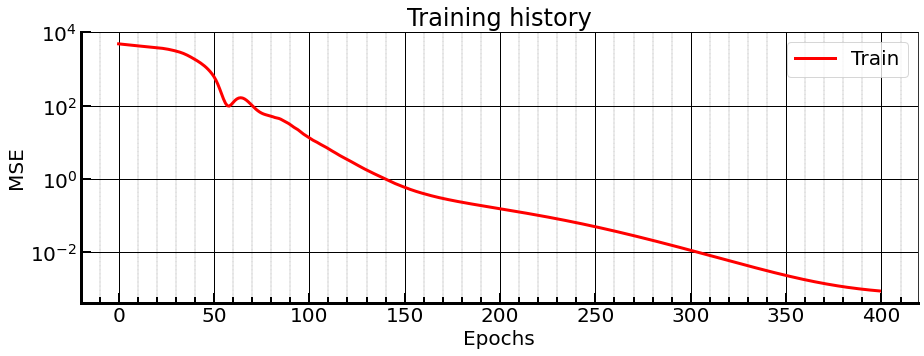

In [13]:
plotLearningHistory(history)


- Look at the learning history.
- Is there a conection with **double descent**? Probably we have too little data to conclude anything here.



In [14]:
predictNextValue(model, array([70, 80, 90]))

(1, 3)
Predict next value in the sequence:  100.34519



- Why is the results not exactly 100?
    - First of all the results are close to the real value we human expect.
    - ANNs should not overfit, they need to generalise hence we should expect the trend is capture but not the exact value.
    - If you need a pefect fit and you are able to come with a rule, then you better implement a rule-based approach.



# Stacked LSTM


- Multiple hidden LSTM layers can be stacked **one on top of another** in what is referred to as a Stacked LSTM model.



In [15]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model1.add(LSTM(50, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

In [16]:
# Fit model
history1 = model1.fit(X, y, epochs = 400, verbose = 0)

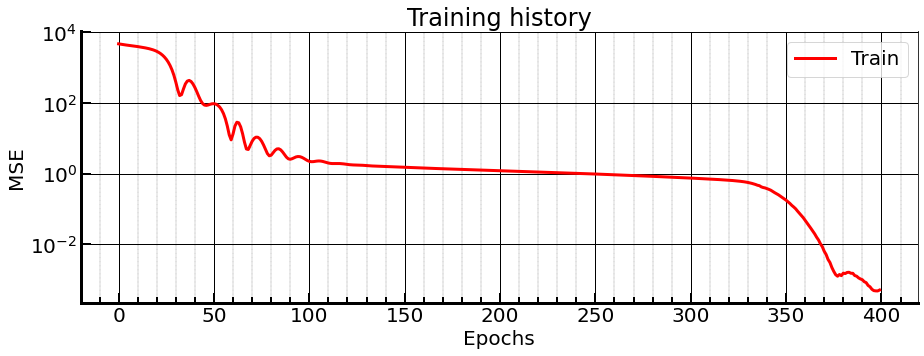

In [17]:
plotLearningHistory(history1)

In [18]:
predictNextValue(model1, array([70, 80, 90]))

(1, 3)
Predict next value in the sequence:  100.49932


# Bidirectional LSTM


- On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.
- This is called a **Bidirectional LSTM**.
- 



In [19]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(50, activation = 'relu'), input_shape=(n_steps, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [20]:
# Fit model
history2 = model2.fit(X, y, epochs = 400, verbose = 0)

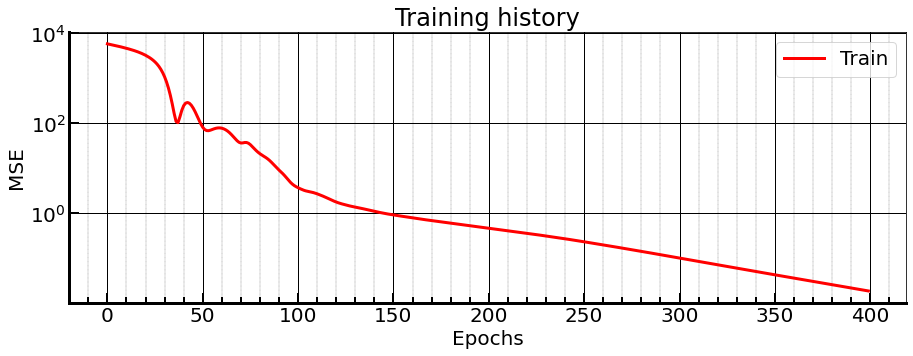

In [21]:
plotLearningHistory(history2)

In [22]:
predictNextValue(model2, array([70, 80, 90]))

(1, 3)
Predict next value in the sequence:  100.614815


In [23]:
predictNextValue(model2, array([80, 90, 100]))

(1, 3)
Predict next value in the sequence:  111.63784


# CNN LSTM


- A convolutional neural network, or CNN for short, is a type of neural network developed for working with two-dimensional image data.
- The CNN can be very effective at **automatically extracting** and learning features from one-dimensional sequence data such as univariate time series data.
- A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.
- The first step is to split the input sequences into subsequences that can be processed by the CNN model. For example, we can first split our univariate time series data into input/output samples with four steps as input and one as output. Each sample can then be split into two sub-samples, each with two time steps. The CNN can interpret each subsequence of two time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.



In [24]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps_ = 2
X = X.reshape((X.shape[0], n_seq, n_steps_, n_features))


- We want to reuse the same CNN model when reading in each sub-sequence of data separately.

- This can be achieved by wrapping the entire CNN model in a TimeDistributed wrapper that will apply the entire model once per input, in this case, once per input subsequence.

- The CNN model first has a convolutional layer for reading across the subsequence that requires a number of filters and a kernel size to be specified. The number of filters is the number of reads or interpretations of the input sequence. The kernel size is the number of time steps included of each ‘read’ operation of the input sequence.

- The convolution layer is followed by a max pooling layer that distills the filter maps down to 1/2 of their size that includes the most salient features. These structures are then flattened down to a single one-dimensional vector to be used as a single input time step to the LSTM layer.



In [25]:
# define model
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=64, 
                                 kernel_size=1, 
                                 activation='relu'), 
                                 input_shape=(None, n_steps_, n_features)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(50, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

In [26]:
# Fit model
history3 = model3.fit(X, y, epochs = 400, verbose = 0)

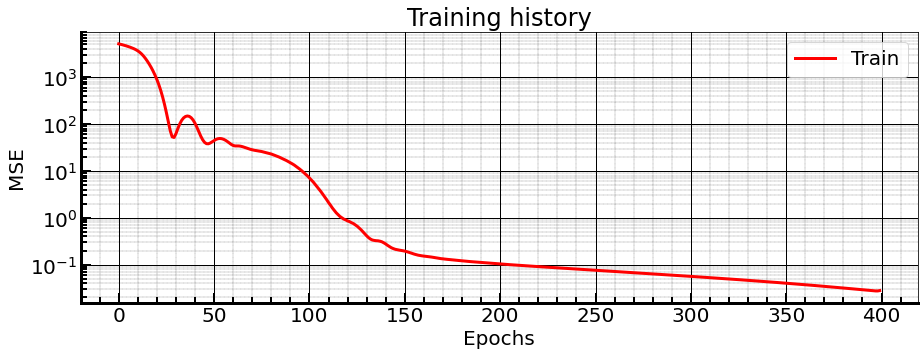

In [27]:
plotLearningHistory(history3)

In [28]:
predictNextValue(model3, array([60, 70, 80, 90]), conv = True)

(1, 4)
Predict next value in the sequence:  100.91567


In [29]:
predictNextValue(model3, array([70, 80, 90, 100]), conv = True)

(1, 4)
Predict next value in the sequence:  111.95359


# ConvLSTM


- A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

- The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

- The layer expects input as a sequence of two-dimensional images, therefore the shape of input data must be:
`[samples, timesteps, rows, columns, features]`

- For our purposes, we can split each sample into subsequences where timesteps will become the number of subsequences, or n_seq, and columns will be the number of time steps for each subsequence, or n_steps. The number of rows is fixed at 1 as we are working with one-dimensional data.

- We can now reshape the prepared samples into the required structure.  



In [30]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps_ = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps_, n_features))

In [31]:
# Define model
model4 = Sequential()
model4.add(ConvLSTM2D(filters=64, 
                      kernel_size=(1,2), 
                      activation='relu', 
                      input_shape=(n_seq, 1, n_steps, n_features)))
model4.add(Flatten())
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')

In [32]:
# Fit model
model4.fit(X, y, epochs=500, verbose=0)

ValueError: in user code:

    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/trainingAI/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2, 1, 4, 1), found shape=(None, 2, 1, 2, 1)


# References
<hr style="border:2px solid black"> </hr>


- https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

